In [ ]:
import pandas as pd
train_data = train_data = pd.read_csv('/content/train_40k.csv')
train_data

,productId,Title,userId,Helpfulness,Score,Time,Text,Cat1,Cat2,Cat3
0,B000E46LYG,Golden Valley Natural Buffalo Jerky,A3MQDNGHDJU4MK,0/0,3.0,-1,The description and photo on this product need...,grocery gourmet food,meat poultry,jerky
1,B000GRA6N8,Westing Game,unknown,0/0,5.0,860630400,This was a great book!!!! It is well thought t...,toys games,games,unknown
2,B000GRA6N8,Westing Game,unknown,0/0,5.0,883008000,"I am a first year teacher, teaching 5th grade....",toys games,games,unknown
3,B000GRA6N8,Westing Game,unknown,0/0,5.0,897696000,I got the book at my bookfair at school lookin...,toys games,games,unknown
4,B00000DMDQ,I SPY A is For Jigsaw Puzzle 63pc,unknown,2/4,5.0,911865600,Hi! I'm Martine Redman and I created this puzz...,toys games,puzzles,jigsaw puzzles
...,...,...,...,...,...,...,...,...,...,...
39995,B0006IYND6,Japonesque Silver Lipstick Palette Kit 1 piece,A1WKFQYYRJ95F6,0/0,3.0,1344211200,Even when it is very convenient I find it real...,beauty,makeup,lips
39996,B000A33FZY,"Truform 20-30 Below Knee Closed-Toe, Beige, Small",A1OMZID10X2JY4,0/0,5.0,1344211200,Wore these the next day after eating Chinese t...,health personal care,medical supplies equipment,braces
39997,B000I7D2L4,Zadro Z300 Wall Mountable Fog Free Mirror,A3I8EYB4CKPQVO,0/0,3.0,1344211200,"this is an OK product. Doesn't really stay ""fo...",beauty,tools accessories,mirrors
39998,B000KHKKB2,Opalescent Glitter Lotion - 6.3 oz - Liquid,A3GTQQ5ZFCFBBL,0/0,4.0,1344211200,"This ""Glitter-Up"" body lotion offers tremendou...",beauty,skin care,body


In [ ]:
print('Первый класс:',train_data['Cat1'].value_counts())
print('Второй класс:',train_data['Cat2'].value_counts())
print('Третий класс:',train_data['Cat3'].value_counts())

Первый класс: Cat1
toys games              10266
health personal care     9772
beauty                   5846
baby products            5637
pet supplies             4862
grocery gourmet food     3617
Name: count, dtype: int64
Второй класс: Cat2
personal care         2852
dogs                  2610
nutrition wellness    2203
health care           2002
cats                  1779
                      ... 
baby food               40
sauces dips             40
produce                 38
meat seafood            37
small animals           29
Name: count, Length: 64, dtype: int64
Третий класс: Cat3
unknown                    2262
shaving hair removal       1565
vitamins supplements       1315
board games                 924
styling tools               850
                           ... 
stuffing                      1
breadsticks                   1
eggs                          1
chocolate covered fruit       1
spices gifts                  1
Name: count, Length: 464, dtype: int64


<Axes: xlabel='Cat1'>

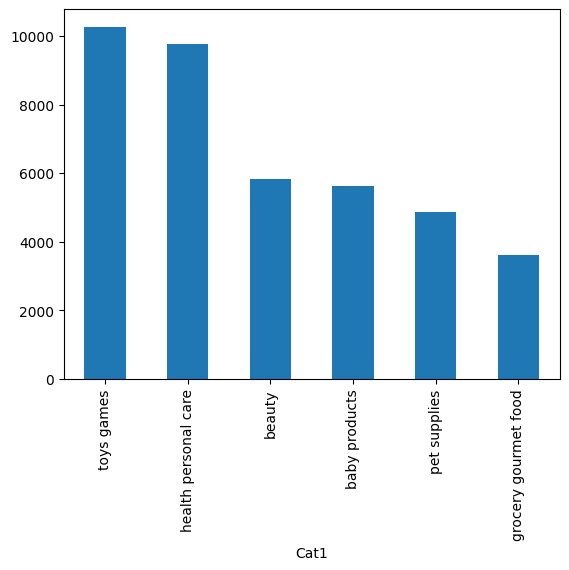

In [ ]:
import seaborn as sns
train_data['Cat1'].value_counts().plot(kind = 'bar')

<Axes: xlabel='Cat2'>

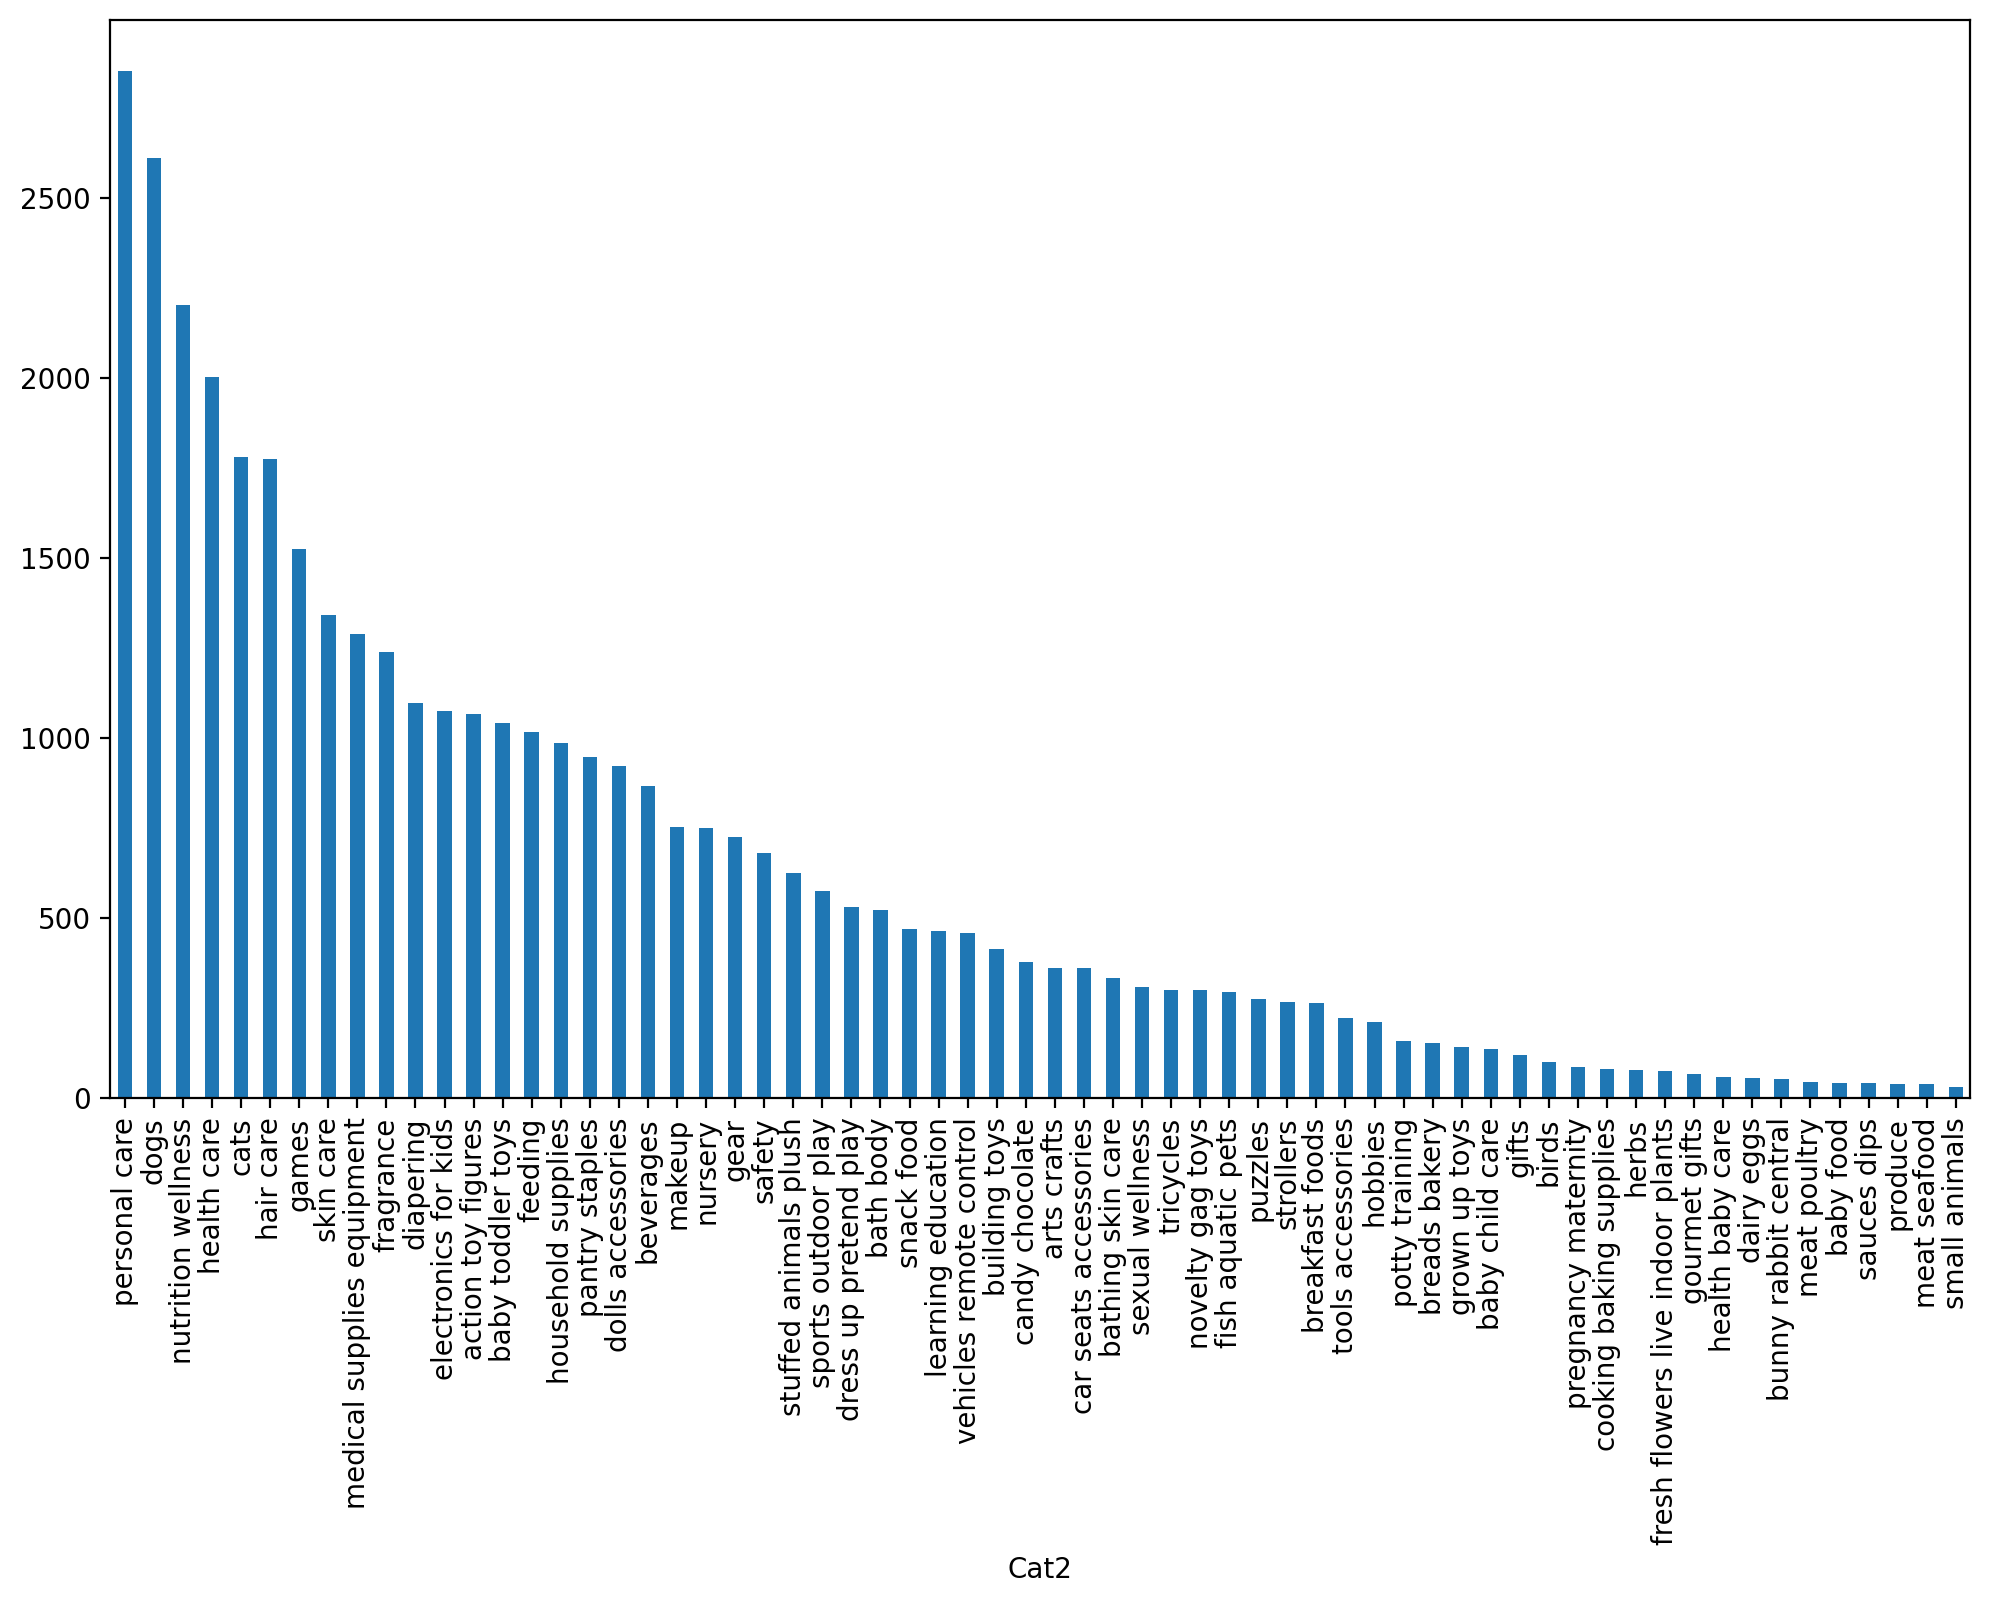

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize = (12,7),dpi = 200)
train_data['Cat2'].value_counts().plot(kind = 'bar')


<Axes: xlabel='Cat3'>

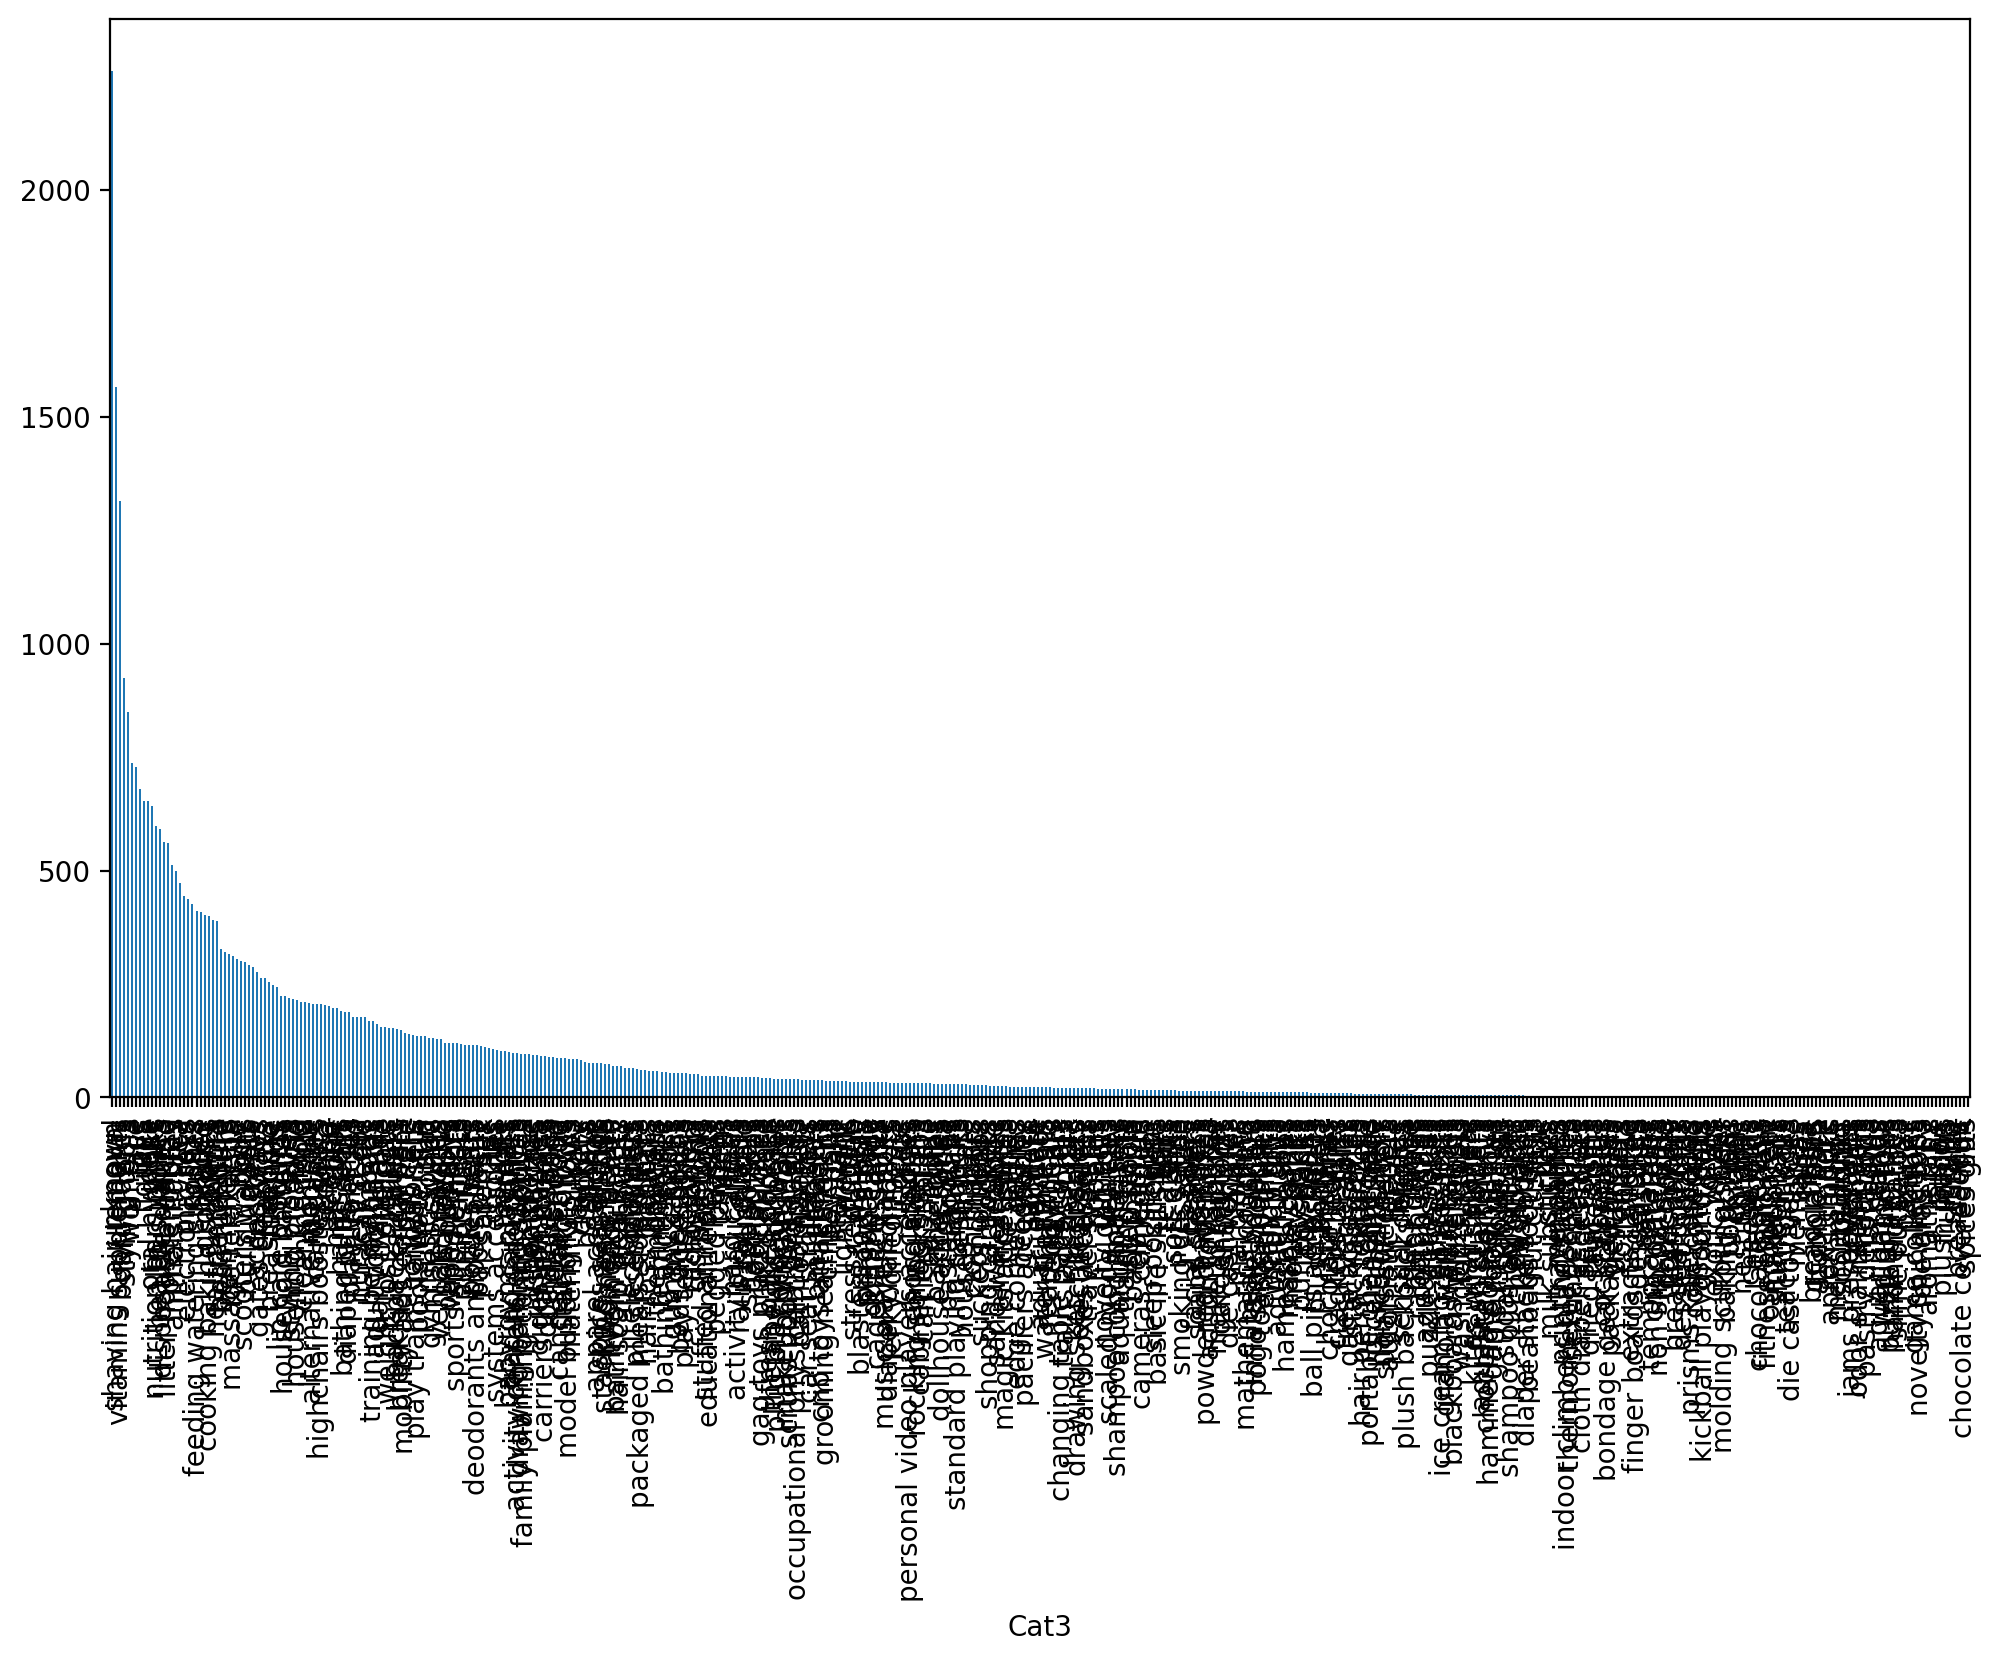

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize = (12,7),dpi = 200)
train_data['Cat3'].value_counts().plot(kind = 'bar')

# 1.Иерархический классификатор

In [10]:
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_array, check_is_fitted

class HierarchicalClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_classifier_for_cat1):
        self.classifier = base_classifier_for_cat1
        self.classifiers_ = {}

    def fit(self, X, y_cat1, y_cat2, y_cat3):

        self.classifiers_['Cat1'] = make_pipeline(
            TfidfVectorizer(max_features = 50000,min_df = 1,ngram_range = (1,1)),
            clone(self.classifier)
            ).fit(X, y_cat1)

        for category in y_cat1.unique():
            mask = y_cat1 == category
            if mask.any():
                y_subset = y_cat2[mask]
                if len(y_subset.unique()) > 1:
                    classifier = make_pipeline(
                        TfidfVectorizer(max_features = 50000,min_df = 1,ngram_range = (1,1)),
                        clone(self.classifier)
                    )
                    self.classifiers_['Cat2_' + category] = classifier.fit(X[mask], y_subset)
                else:
                    print(f"Skipping training for Cat2_{category} due to single class: '{y_subset.unique()[0]}'")

        for category in y_cat2.unique():
            mask = y_cat2 == category
            if mask.any():
                y_subset = y_cat3[mask]
                if len(y_subset.unique()) > 1:
                    classifier = make_pipeline(
                        TfidfVectorizer(max_features = 50000,min_df = 1,ngram_range = (1,1)),
                        clone(self.classifier)
                    )
                    self.classifiers_['Cat3_' + category] = classifier.fit(X[mask], y_subset)
                else:
                    print(f"Skipping training for Cat3_{category} due to single class: '{y_subset.unique()[0]}'")

        return self

    def predict(self, X):
        y_pred_cat1 = self.classifiers_['Cat1'].predict(X)

        y_pred_cat2 = []
        y_pred_cat3 = []

        for i, x in enumerate(X):
            cat1 = str(y_pred_cat1[i])
            cat2_classifier_key = 'Cat2_' + cat1
            if cat2_classifier_key in self.classifiers_:
                cat2 = str(self.classifiers_[cat2_classifier_key].predict([x])[0])
            else:
                cat2 = ''
            y_pred_cat2.append(cat2)

            cat3_classifier_key = 'Cat3_' + cat2
            if cat3_classifier_key in self.classifiers_:
                cat3 = str(self.classifiers_[cat3_classifier_key].predict([x])[0])
            else:
                cat3 = ''
            y_pred_cat3.append(cat3)

        return y_pred_cat1, y_pred_cat2, y_pred_cat3



In [3]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 5.9 MB/s eta 0:00:00


In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import nltk
import pymorphy2
import string
from nltk.corpus import stopwords
import re
from tqdm import tqdm_notebook
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

def preprop_text(text):
    nums_filtered_text = re.sub(r'[0-9]+', '', text.lower())
    punct_filtered_text = ''.join([ch for ch in nums_filtered_text if ch not in string.punctuation])
    tokens = nltk.WordPunctTokenizer().tokenize(punct_filtered_text)
    filtr_stop_words_tokens = [pymorphy2.MorphAnalyzer().parse(token)[0].normal_form for token in tokens
                             if token not in set(stopwords.words('english'))]

    norm_tokens = [pymorphy2.MorphAnalyzer().parse(token)[0].normal_form for token in filtr_stop_words_tokens]

    return f"{' '.join(norm_tokens)}"


from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()

    text = re.sub(r'[^a-z\s]', '', text)

    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in set(stopwords.words('english'))]

    text = ' '.join(words)

    return text

import pandas as pd
train_df = pd.read_csv("/content/train_40k.csv")
X_train = train_df['Text']
y_train_cat1 = train_df['Cat1']

#X_train = X_train.apply(lambda x: preprocess_text(x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

X_train = train_df['Text']
y_train_cat1 = train_df['Cat1']

param_grid = {
    'tfidf__max_features': [5000, 10000, 50000],
    'tfidf__min_df': [1, 2, 5],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'clf__C': [1e1, 1e2, 1e3],
    'clf__solver': ['lbfgs', 'liblinear']
}

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression())
])

grid_search = GridSearchCV(pipeline, param_grid, cv=3, verbose=1, n_jobs=-1)

import time
start = time.time()
grid_search.fit(X_train, y_train_cat1)
finish = time.time()
print(f"GridSearchCV обучение заняло {finish - start} секунд")

print("Лучшие параметры:", grid_search.best_params_)


Fitting 3 folds for each of 108 candidates, totalling 324 fits
GridSearchCV обучение заняло 4548.9458174705505 секунд
Лучшие параметры: {'clf__C': 10.0, 'clf__solver': 'liblinear', 'tfidf__max_features': 50000, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 1)}


# 2,3 Обучение иерарзического классификатора

In [25]:
import pandas as pd
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
import joblib
from catboost import CatBoostClassifier

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm_notebook
import re
import nltk
nltk.download('wordnet')

import time

val_df = pd.read_csv("/content/val_10k.csv")

y_train_cat1 = train_df['Cat1']
y_train_cat2 = train_df['Cat2']
y_train_cat3 = train_df['Cat3']

X_val = val_df['Text']
y_val_cat1 = val_df['Cat1']
y_val_cat2 = val_df['Cat2']
y_val_cat3 = val_df['Cat3']

hierarchical_clf = HierarchicalClassifier(base_classifier_for_cat1 =  LogisticRegression(C = 10,solver = 'liblinear'))

start = time.time()
hierarchical_clf.fit(X_train, y_train_cat1, y_train_cat2, y_train_cat3)
finish = time.time()
print(finish - start,'cекунд заняло обучение')
#joblib.dump(hierarchical_clf,'model.joblib')

y_pred_cat1, y_pred_cat2, y_pred_cat3 = hierarchical_clf.predict(X_val)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Skipping training for Cat3_tricycles due to single class: 'scooters wagons'
Skipping training for Cat3_pregnancy maternity due to single class: 'maternity pillows'
Skipping training for Cat3_herbs due to single class: 'spices seasonings'
50.97857618331909 cекунд заняло обучение


# 4. Обучение плоского классификатора

In [39]:
train_df['Cat1_Cat2_Cat3'] = train_df['Cat1'] + '/' + train_df['Cat2'] + '/' + train_df['Cat3']
val_df['Cat1_Cat2_Cat3'] = val_df['Cat1'] + '/' + val_df['Cat2'] + '/' + val_df['Cat3']

tf_idf = TfidfVectorizer(max_features = 50000,min_df = 1,ngram_range = (1,1))

logit = LogisticRegression(C = 10, solver = 'liblinear',multi_class = 'multinomial')

from sklearn.pipeline import Pipeline
tfidf_logit_pipeline = Pipeline([('tf_idf', tf_idf),
                                 ('logit', logit)])


In [40]:
%%time
tfidf_logit_pipeline.fit(train_df['Text'], train_df['Cat1_Cat2_Cat3'])

CPU times: user 21min 3s, sys: 2.9 s, total: 21min 6s
Wall time: 12min 30s


Pipeline(steps=[('tf_idf', TfidfVectorizer(max_features=50000)),
                ('logit', LogisticRegression(C=10, solver='liblinear'))])

# 5. Сравнение моделей

После проведение обучения иерерхического и плоского классификаторов получилось, что время обучения для **иерархического составило 64 секунды**, а для **плоского 587 секунд**, но важно подметить, что иерархический метод больше расходует CPU нежели прямой.

Касаемо метрик можно заметить, что плоский метод лучше прогнозирует, нежели иерархический

In [38]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Иерархический алгоритм
print("Cat1 - Accuracy:", accuracy_score(y_val_cat1, y_pred_cat1))
print("Cat1 - Precision:", precision_score(y_val_cat1, y_pred_cat1, average='macro'))
print("Cat1 - Recall:", recall_score(y_val_cat1, y_pred_cat1, average='macro'))
print("Cat1 - F1 Score:", f1_score(y_val_cat1, y_pred_cat1, average='macro'))
print('\n')
print("Cat2 - Accuracy:", accuracy_score(y_val_cat2, y_pred_cat2))
print("Cat2 - Precision:", precision_score(y_val_cat2, y_pred_cat2, average='macro'))
print("Cat2 - Recall:", recall_score(y_val_cat2, y_pred_cat2, average='macro'))
print("Cat2 - F1 Score:", f1_score(y_val_cat2, y_pred_cat2, average='macro'))
print('\n')
print("Cat3 - Accuracy:", accuracy_score(y_val_cat3, y_pred_cat3))
print("Cat3 - Precision:", precision_score(y_val_cat3, y_pred_cat3, average = 'macro'))
print("Cat3 - Recall:", recall_score(y_val_cat3, y_pred_cat3, average ='macro'))
print("Cat3 - F1 Score:", f1_score(y_val_cat3, y_pred_cat3, average='macro'))

Cat1 - Accuracy: 0.8068
Cat1 - Precision: 0.8019167954256218
Cat1 - Recall: 0.7895820249385054
Cat1 - F1 Score: 0.794618309076993


Cat2 - Accuracy: 0.5944


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Cat2 - Precision: 0.5408324133037192
Cat2 - Recall: 0.40508452866361433
Cat2 - F1 Score: 0.4250482248370427


Cat3 - Accuracy: 0.4659
Cat3 - Precision: 0.28767474199358944
Cat3 - Recall: 0.21133951080242258
Cat3 - F1 Score: 0.2166567039948845


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Иерархический алгоритм СatBoost
print("Cat1 - Accuracy:", accuracy_score(y_val_cat1, y_pred_cat1))
print("Cat1 - Precision:", precision_score(y_val_cat1, y_pred_cat1, average='macro'))
print("Cat1 - Recall:", recall_score(y_val_cat1, y_pred_cat1, average='macro'))
print("Cat1 - F1 Score:", f1_score(y_val_cat1, y_pred_cat1, average='macro'))
print('\n')
print("Cat2 - Accuracy:", accuracy_score(y_val_cat2, y_pred_cat2))
print("Cat2 - Precision:", precision_score(y_val_cat2, y_pred_cat2, average='macro'))
print("Cat2 - Recall:", recall_score(y_val_cat2, y_pred_cat2, average='macro'))
print("Cat2 - F1 Score:", f1_score(y_val_cat2, y_pred_cat2, average='macro'))
print('\n')
print("Cat3 - Accuracy:", accuracy_score(y_val_cat3, y_pred_cat3))
print("Cat3 - Precision:", precision_score(y_val_cat3, y_pred_cat3, average = 'macro'))
print("Cat3 - Recall:", recall_score(y_val_cat3, y_pred_cat3, average ='macro'))
print("Cat3 - F1 Score:", f1_score(y_val_cat3, y_pred_cat3, average='macro'))

Cat1 - Accuracy: 0.525
Cat1 - Precision: 0.6868524921902845
Cat1 - Recall: 0.428744327490525
Cat1 - F1 Score: 0.46733100486933044


Cat2 - Accuracy: 0.0
Cat2 - Precision: 0.0
Cat2 - Recall: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Cat2 - F1 Score: 0.0


Cat3 - Accuracy: 0.0
Cat3 - Precision: 0.0
Cat3 - Recall: 0.0
Cat3 - F1 Score: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [41]:
valid_pred_level_3 = tfidf_logit_pipeline.predict(val_df['Text'])
valid_pred_level_1 = [el.split('/')[0] for el in valid_pred_level_3]
valid_pred_level_2 = [el.split('/')[1] for el in valid_pred_level_3]

In [42]:
# Плоский метод
print("Cat1 - Accuracy:", accuracy_score(val_df['Cat1'],valid_pred_level_1))
print("Cat1 - Precision:", precision_score(val_df['Cat1'],valid_pred_level_1, average='macro'))
print("Cat1 - Recall:", recall_score(val_df['Cat1'],valid_pred_level_1,average='macro'))
print("Cat1 - F1 Score:", f1_score(val_df['Cat1'],valid_pred_level_1, average = 'macro'))
print('\n')
print("Cat2 - Accuracy:", accuracy_score(val_df['Cat2'],valid_pred_level_2))
print("Cat2 - Precision:", precision_score(val_df['Cat2'],valid_pred_level_2, average='macro'))
print("Cat2 - Recall:", recall_score(val_df['Cat2'],valid_pred_level_2, average='macro'))
print("Cat2 - F1 Score:", f1_score(val_df['Cat2'],valid_pred_level_2, average='macro'))
print('\n')
print("Cat3 - Accuracy:", accuracy_score(val_df['Cat1_Cat2_Cat3'],valid_pred_level_3))
print("Cat3 - Precision:", precision_score(val_df['Cat1_Cat2_Cat3'],valid_pred_level_3, average = 'macro'))
print("Cat3 - Recall:", recall_score(val_df['Cat1_Cat2_Cat3'],valid_pred_level_3, average ='macro'))
print("Cat3 - F1 Score:", f1_score(val_df['Cat1_Cat2_Cat3'],valid_pred_level_3, average='macro'))

Cat1 - Accuracy: 0.7782
Cat1 - Precision: 0.7892021441218772
Cat1 - Recall: 0.7429477216499043
Cat1 - F1 Score: 0.7610951220195111


Cat2 - Accuracy: 0.5875


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Cat2 - Precision: 0.5807506124116427
Cat2 - Recall: 0.40083629159382544
Cat2 - F1 Score: 0.4308318645752187


Cat3 - Accuracy: 0.4831


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Cat3 - Precision: 0.3000558535026106
Cat3 - Recall: 0.2072766232231799
Cat3 - F1 Score: 0.22213991776703124


In [ ]:
print(f'{sum(1 for a, b in zip(y_pred_cat1[:-1], valid_pred_level_1[:-1]) if a == b) / len(y_pred_cat1) * 100}% совпадения первых классов')
print(f'{sum(1 for a, b in zip(y_pred_cat2[:-1], valid_pred_level_2[:-1]) if a == b) / len(y_pred_cat2) * 100}% совпадения вторых классов')
print(f'{sum(1 for a, b in zip(y_pred_cat3[:-1], valid_pred_level_3[:-1]) if a == b) / len(y_pred_cat3) * 100}% совпадения третьих классов')

79.13% совпадения первых классов
64.4% совпадения вторых классов
0.0% совпадения третьих классов


# 7. Анализ проблемных точек

In [ ]:
!pip install pyinstrument

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.5/126.5 kB 1.3 MB/s eta 0:00:00


In [ ]:
import pyinstrument

profiler = pyinstrument.Profiler()
profiler.start()

y_pred_hierarchical = hierarchical_clf.predict(X_val)

profiler.stop()
print(profiler.output_text(unicode=True, color=True))


  _     ._   __/__   _ _  _  _ _/_   Recorded: 13:43:26  Samples:  44152
 /_//_/// /_\ / //_// / //_'/ //     Duration: 53.305    CPU time: 43.669
/   _/                      v4.7.2

Profile at <ipython-input-13-2417bedb69d8>:4

53.304 Shell.run_code  IPython/core/interactiveshell.py:3512
└─ 53.304 <cell line: 6>  <ipython-input-13-2417bedb69d8>:1
   └─ 53.304 HierarchicalClassifier.predict  <ipython-input-4-f1f0577a3bd2>:46
      └─ 52.672 Pipeline.predict  sklearn/pipeline.py:483
            [80 frames hidden]  sklearn, inspect, scipy, <built-in>, ...




Основное время в коде уходит на выполнение метода predict класса HierarchicalClassifier, который, в свою очередь, использует метод Pipeline.predict

Практически всё время затрачивается на выполнение предсказаний, что включает в себя обработку текста (векторизацию с помощью TfidfVectorizer) и предсказание с помощью модели

**Решение проблемы:**

1. Каждый раз, когда вызывается predict, происходит преобразование текста в числовые признаки с использованием TfidfVectorizer. Если одни и те же данные используются несколько раз, это приводит к избыточной работе. Поэтому есть идея прокешировать данные, чтоб использовать их повторно

2. Можно подобрать параметры для TfIdf, так как max_features и min_df прямолинейно влияют на скорость выполнения алгоритма. Можно попробовать уменьшить количество признаков (max_features) или увеличить минимальную частоту слов (min_df) для улучшения производительности

3. Попробовать использовать joblib или concurrent.futures для параллельного выполнения предсказаний на каждом уровне

# ЗАДАНИЕ 6 В ДРУГОЙ ПАПКЕ

In [2]:
!pip install datasets

In [2]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 10.1 MB/s eta 0:00:00


In [1]:
!pip install pymorphy2

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 71.4 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13704 sha256=4124aa034d49699ef1a45897c627766b07f6e473b9ca8930d33066fdf2b3b767
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [5]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 7.5 MB/s eta 0:00:00


In [6]:
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from catboost import CatBoostClassifier

#Обучение CatBoost(результаты во втором задании)
class HierarchicalClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_classifier_params=None):
        if base_classifier_params is None:
            base_classifier_params = {
                'iterations': 100,
                'depth': 6,
                'learning_rate': 0.1,
                'loss_function': 'MultiClass',
                'verbose': 0
            }
        self.classifier_params = base_classifier_params
        self.classifiers_ = {}

    def fit(self, X, y_cat1, y_cat2, y_cat3):
        # Обучение классификатора на первом уровне (Cat1)
        self.classifiers_['Cat1'] = CatBoostClassifier(**self.classifier_params)
        self.classifiers_['Cat1'].fit(X, y_cat1)

        # Обучение классификаторов на втором уровне (Cat2)
        for category in y_cat1.unique():
            mask = y_cat1 == category
            if mask.any():
                y_subset = y_cat2[mask]
                if len(y_subset.unique()) > 1:
                    clf = CatBoostClassifier(**self.classifier_params)
                    clf.fit(X[mask], y_subset)
                    self.classifiers_['Cat2_' + category] = clf

        # Обучение классификаторов на третьем уровне (Cat3)
        for category in y_cat2.unique():
            mask = y_cat2 == category
            if mask.any():
                y_subset = y_cat3[mask]
                if len(y_subset.unique()) > 1:
                    clf = CatBoostClassifier(**self.classifier_params)
                    clf.fit(X[mask], y_subset)
                    self.classifiers_['Cat3_' + category] = clf

        return self

    def predict(self, X):
        y_pred_cat1 = self.classifiers_['Cat1'].predict(X)

        y_pred_cat2 = []
        y_pred_cat3 = []

        for i, x in enumerate(X):
            cat1 = y_pred_cat1[i]
            cat2_classifier_key = 'Cat2_' + cat1
            if cat2_classifier_key in self.classifiers_:
                cat2 = self.classifiers_[cat2_classifier_key].predict([x])[0]
            else:
                cat2 = ''
            y_pred_cat2.append(cat2)

            cat3_classifier_key = 'Cat3_' + cat2
            if cat3_classifier_key in self.classifiers_:
                cat3 = self.classifiers_[cat3_classifier_key].predict([x])[0]
            else:
                cat3 = ''
            y_pred_cat3.append(cat3)

        return y_pred_cat1, y_pred_cat2, y_pred_cat3
